In [1]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidi

In [2]:
import datasets
from datasets import load_dataset
import os
import librosa
import gc
import ast
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import torchaudio
import sys
import json
from datasets import load_dataset
from evaluate import load
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import torchaudio
import torch
from transformers import ASTFeatureExtractor, ASTConfig, ASTForAudioClassification, TrainingArguments, Trainer
os.environ["WANDB_DISABLED"] = "true"

import kagglehub
path = kagglehub.dataset_download("mohammedabdeldayem/the-fake-or-real-dataset")

2025-07-23 12:30:24.541581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753273824.727547      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753273824.780867      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
dataset = datasets.load_dataset("audiofolder", data_dir = "/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm")
dataset

Resolving data files:   0%|          | 0/53868 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/10798 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/4634 [00:00<?, ?it/s]

In [ ]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

# Feature Extractor

In [ ]:
feature_extractor = ASTFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

# Preprocessing

In [ ]:
def is_valid_audio(example):
    return example["audio"]["array"] is not None and len(example["audio"]["array"]) >= 400

dataset["train"] = dataset["train"].filter(is_valid_audio)
dataset["test"] = dataset["test"].filter(is_valid_audio)
dataset["validation"] = dataset["validation"].filter(is_valid_audio)

In [ ]:
max_duration = 5.0

def preprocess_function(examples):
    audio_array = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_array,
        sampling_rate = feature_extractor.sampling_rate,
        max_length = int(feature_extractor.sampling_rate * max_duration),
        truncation = True,
    )
    return inputs

In [ ]:
encoded_dataset = dataset.map(preprocess_function, remove_columns=["audio"], batched=True)
encoded_dataset

# Define Audio Spectrogram Transformer

In [ ]:
modelAST = ASTForAudioClassification.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593",
    num_labels = len(labels),
    label2id = label2id,
    id2label = id2label,
    ignore_mismatched_sizes=True
)

# Training Arguments

In [ ]:
arguments = TrainingArguments(
    f"ast-finetuned-audioset-10-10-0.4593-finetuned-ks",
    eval_strategy = "epoch",
    save_strategy = "epoch",

    learning_rate=3e-5,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    
)

In [18]:
metric = load("accuracy")

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis = 1)
    return metric.compute(predictions = predictions, references = eval_pred.label_ids)

# Training

In [ ]:
trainAST = Trainer(
    modelAST,
    arguments,
    train_dataset = encoded_dataset['train'],
    eval_dataset = encoded_dataset['validation'],
    tokenizer = feature_extractor,
    compute_metrics = compute_metrics
)

In [ ]:
trainAST.train()

# Visualization

In [13]:
with open("/kaggle/input/ast/other/default/1/ast-finetuned-audioset-10-10-0.4593-finetuned-ks/checkpoint-2526/trainer_state.json", "r") as f:
    trainer_state = json.load(f)
training_history = trainer_state["log_history"]

epochs, acc, loss = [], [], []
for i in training_history:
    if i["epoch"] % 1 == 0 or i["epoch"] % 2 == 0:
        epochs.append(i['epoch'])
        acc.append(i['eval_accuracy'])
        loss.append(i['eval_loss'])

history = dict()
history['epoch'] = epochs
history['eval_accuracy'] = acc
history['eval_loss'] = loss

In [14]:
def plotResults(history, model_name='Model'):
    metrics = ['eval_loss', 'eval_accuracy']
    epochs = range(1, len(history['epoch']) + 1)
    fig, axes = plt.subplots(1, len(metrics), figsize=(6 * len(metrics), 5))
    if len(metrics) == 1:
        axes = [axes]
    for i, metric in enumerate(metrics):
        ax = axes[i]
        ax.plot(epochs, history[metric], label=f'Val {metric}', marker='o')
        ax.set_title(f'{metric} over Epochs')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric)
        ax.legend()
        ax.grid(True)
    plt.suptitle(model_name, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


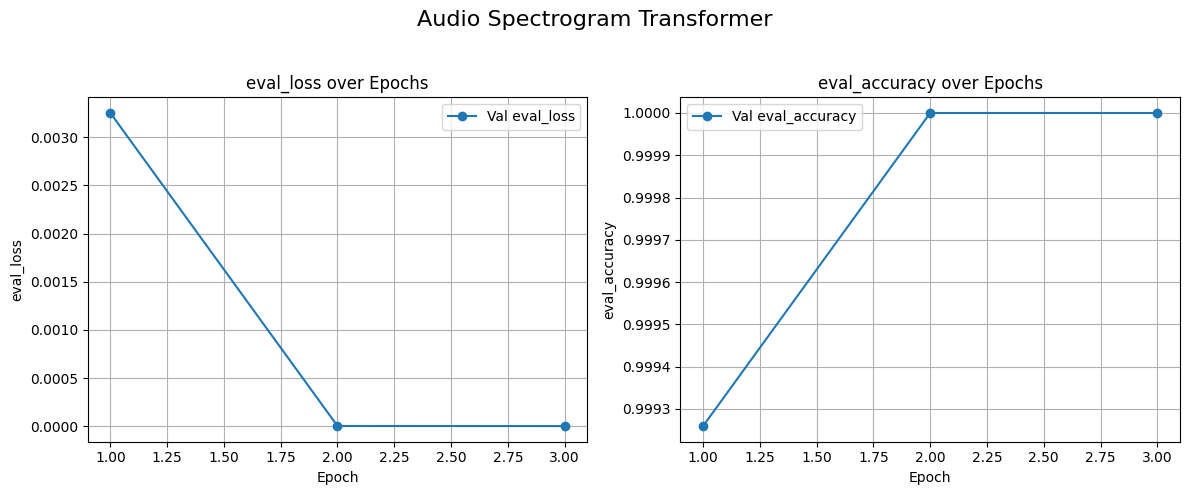

In [15]:
plotResults(history, model_name = 'Audio Spectrogram Transformer')

# Save Model

In [ ]:
trainAST.save_model("/kaggle/working/AST")
feature_extractor.save_pretrained("/kaggle/working/AST")

# Load Model

In [30]:
feature_extractor = ASTFeatureExtractor.from_pretrained("/kaggle/input/ast/other/default/1/AST")
AST = ASTForAudioClassification.from_pretrained("/kaggle/input/ast/other/default/1/AST")

# Evaluation

In [31]:
training_args = TrainingArguments(
    output_dir="/kaggle/input/ast/other/default/1/AST",
    do_eval=True,
    per_device_eval_batch_size=8,
    logging_dir=None,
    report_to=[],
    logging_strategy="no",
)

trainer = Trainer(
    model=AST,
    args=training_args,
    eval_dataset = encoded_dataset["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

/tmp/ipykernel_36/1597075256.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [32]:
results = trainer.evaluate()
print(f"Evaluation Loss: {results['eval_loss']}")
print(f"Evaluation Accuracy: {results['eval_accuracy']}")

Evaluation Loss: 6.524808883666992
Evaluation Accuracy: 0.48921018558480794


In [33]:
logits = trainer.predict(encoded_dataset["test"])
predicted = logits.predictions.argmax(axis = -1)
grouth_true = logits.label_ids

accuracy = metrics.accuracy_score(grouth_true, predicted)
precision = metrics.precision_score(grouth_true, predicted, average = 'weighted')
f1 = metrics.f1_score(grouth_true, predicted, average = 'weighted')
recall = metrics.recall_score(grouth_true, predicted, average = 'weighted')
roc_auc = metrics.roc_auc_score(grouth_true, predicted, average = 'weighted')
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"F1: {f1}")
print(f"Recall: {recall}")
print(f"ROC_AUC: {roc_auc}")

Accuracy: 0.48921018558480794
Precision: 0.7502854373059825
F1: 0.3221361203274797
Recall: 0.48921018558480794
ROC_AUC: 0.5006329113924051


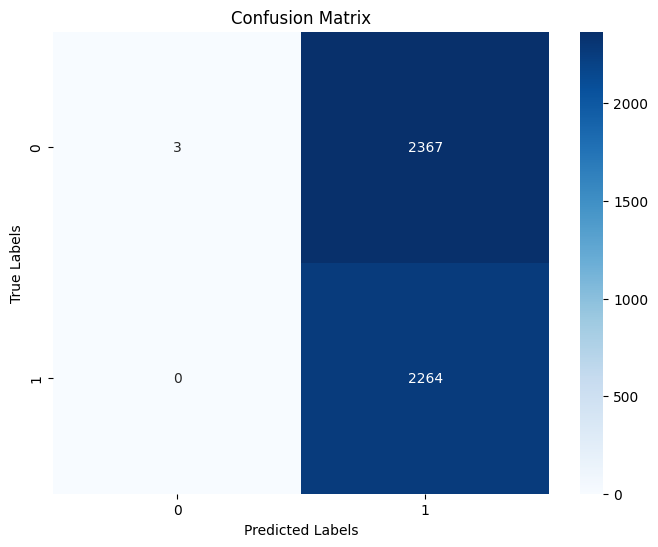

In [34]:
confusion_matrix = metrics.confusion_matrix(grouth_true, predicted)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Inference

In [35]:
def inference(file_path, model, feature_extractor, label_mapper = None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    speech, sr = torchaudio.load(file_path)
    if sr != 16000:
        resampler = torchaudio.transforms.Resample(sr, 16000)
        speech = resampler(speech)

    inputs = feature_extractor(speech.squeeze().numpy(), sampling_rate = 16000, return_tensors = 'pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        logits = model(**inputs).logits
        preds = torch.argmax(logits, dim = -1).item()

    if label_mapper:
        return f"Final prediction: {label_mapper(preds)}"
    return f"Final prediction: {preds}"

In [36]:
file_path = "/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/testing/real/file1.wav_16k.wav_norm.wav_mono.wav_silence.wav"
inference(file_path, AST, feature_extractor, encoded_dataset["train"].features["label"].int2str)

'Final prediction: real'